In [10]:
# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle

In [11]:
from draft import Regression_Hertz, Hertz_Dataset, error_fn, plot_error_hist, plot_bad_curves, plot_pred_real_curves

In [12]:
timestamp = '20230418_113903'
model_dir = 'model_{}'.format(timestamp)
parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
dir = 'Hertz_models'
path = os.path.join(parent_dir, dir, model_dir)
# path = os.path.join(initial_wd, dir, model_dir)
os.chdir(path)

print(os.getcwd())

c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\Hertz_models\model_20230418_113903


In [13]:
with open('model_params.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)
    model_params = data[0]

model_params.keys()

dict_keys(['Epochs', 'Learning Rate', 'Batch Size', 'Number of Hidden layers', 'Type of layers', 'Activation function', 'Architecture', 'Hidden Units 1', 'Hidden Units 2', 'Input shape', 'Loss function', 'Optimizer', 'nu', 'radius', 'Model Path'])

In [14]:
# Load test data
x_test_t = torch.load('x_test_t.pt')
y_test_t = torch.load('y_test_t.pt')

nu = float(model_params['nu'])
r = float(model_params['radius'])

# Open pkl files (requires change to directory Train_Validation_Data)
# with open('nested_array.pkl', 'rb') as f:
    # loaded_nested_array = pickle.load(f)

test_data = Hertz_Dataset(x_test_t, y_test_t)

BATCH_SIZE = int(model_params['Batch Size'])
# test_loader=DataLoader(test_data,batch_size=int(test_ratio*size+1),shuffle=False)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Input shape in correct format
input_raw = model_params['Input shape'].strip('][').split(', ')
input_shape = [int(i) for i in input_raw]

#Hidden units
HIDDEN_UNITS_1 = int(model_params['Hidden Units 1'])
HIDDEN_UNITS_2 = int(model_params['Hidden Units 2'])

model_path = model_params['Model Path']
model_path

loss_fn = eval('nn.' + model_params['Loss function']) # [:-2] to remove the parenthesis, 

In [16]:
torch.manual_seed(42)

loaded_model = Regression_Hertz(input_shape=input_shape,
                                HIDDEN_UNITS_1=HIDDEN_UNITS_1,
                                HIDDEN_UNITS_2=HIDDEN_UNITS_2)

# Load in the saved state_dict
loaded_model.load_state_dict(torch.load(f=model_path))

# See model architecture and state_dict (weights and biases)
loaded_model
#loaded_model.state_dict()

Regression_Hertz(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=40, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               error_fn):
    model.eval()
    loss, error = 0, 0
    error_list, fts_list, labels_list, predicts_list = [], [], [], []
    with torch.inference_mode():
        for i, testdata in enumerate(data_loader):
            test_fts, test_labels = testdata
            fts_list.append(test_fts)
            labels_list.append(test_labels)
            y_pred = model(test_fts)
            predicts_list.append(y_pred)
            loss += loss_fn(y_pred, test_labels) 
            error_aux, error_list_aux = error_fn(y_pred, test_labels)
            error += error_aux
            error_list += error_list_aux
        loss /= len(data_loader)
        error /= len(data_loader)
    error2_5 = len([i for i in error_list if i <= 2.5])/len(error_list)
    error5 = len([i for i in error_list if i <= 5])/len(error_list)
    error10 = len([i for i in error_list if i <= 10])/len(error_list)
    
    results_dict = {"model_name": model.__class__.__name__,
                    "model_loss": loss.item(),
                    "model_error": error,
                    "under_5%_error": error5,
                    "under_10%_error": error10}
    
    with open('test_results.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict.keys())
        writer.writeheader()
        writer.writerow(results_dict)
    plot_error_hist(error_list, test=True, error1=error2_5, error2=error10)
    plot_bad_curves(error_list, fts_list, labels_list, test=True)
    plot_pred_real_curves(error_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r)
    print(results_dict)


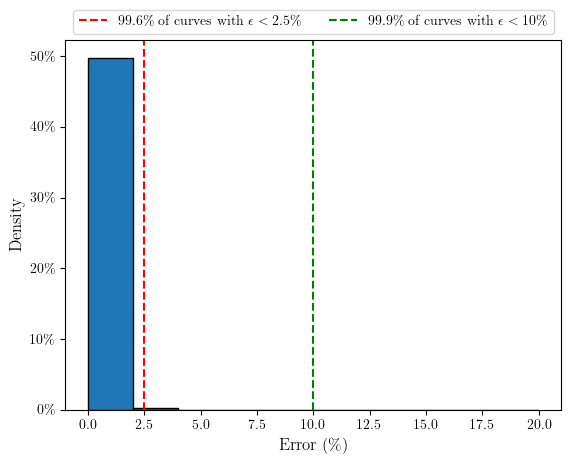

<Figure size 640x480 with 0 Axes>

{'model_name': 'Regression_Hertz', 'model_loss': 5.334373781806789e-06, 'model_error': 0.21560458204847702, 'under_5%_error': 0.9993333333333333, 'under_10%_error': 0.9993333333333333}


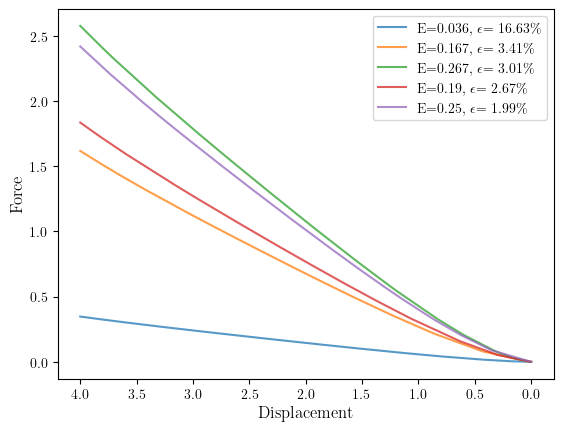

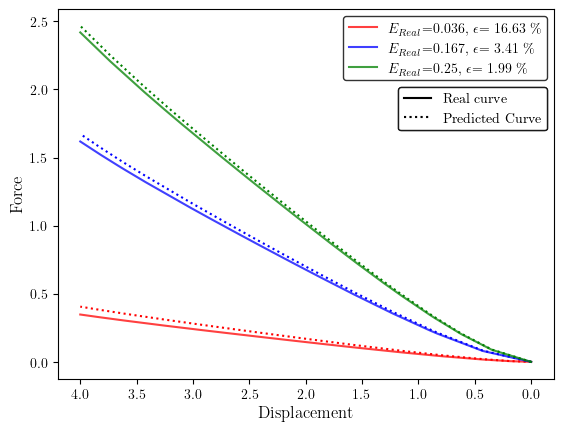

In [18]:
eval_model(loaded_model, test_loader, loss_fn, error_fn)